In [195]:
import spotipy
import spotipy.util as util
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import time
from time import sleep
import seaborn as sns
import numpy as np
from sklearn import preprocessing

'''Get user token to access Spotify API. Token is refreshed periodically, so it's important 
to call this function each time requests are made.'''

# Credentials for Spotify
username = '1242062883'
client_id ='e6265a912d9c4be18688eee8093bb4e8'
client_secret = 'fc27bdc4c3654450960bbb60c38b3fd0'
scope = 'playlist-read-private playlist-modify-private user-read-private'

# Credentials for Deezer
deezer_client_id = '446462'
deezer_client_secret = 'fea9e6460c9d476297b1144853140c8e'

redirect_uri = 'http://localhost:7777/callback'

In [2]:
'''Instantiate Flask server with dash'''
from flask import Flask
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import os
import os.path
from os import path
import chart_studio.plotly as py
from flask_sqlalchemy import SQLAlchemy
import sqlalchemy

server = Flask(__name__)


### Generic Spotify API Calls
The following 3 functions help me do basic Spotify API calls that I will use in more complex functions downstream:
1. Get a track id given a track title and artist
2. Get a track title and artist given a track id
3. Run a keyword search to return all track ids from n playlists searched 

In [3]:
def get_song_id(song_title, artist):
    '''
    Parameters:
        - track title
        - artist
        - Spotify access token
        
    Function: Spotify API GET request using track title and artist to 
    get corresponding Spotify track id
    
    Return: track id
    '''

    query = 'track:' + song_title + ' artist:' + artist

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    params = [
    ('q', query),
    ('type', 'track'),
    ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None

In [4]:
def get_track_artist_album(track_ids):
    '''
    Parameters:
        - list of track ids
        - Spotify access token
        
    Function: Spotify API GET request using track id list to get corresponding
    track names and artists
    
    Return: list of dictionaries where each entry contains track artist, track album, and track name
    '''

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    
    limit = 50
    num_queries = math.ceil(len(track_ids) / limit)
    tracks_aan = []

    for i in range(num_queries):
        start = i*50
        end = start + 50
        if len(track_ids[start:]) >= 50:
            id50_segment = track_ids[start:end]
        else:
            id50_segment = track_ids[start:]
        
        try:
            id50_segment_query = ','.join(id50_segment)
        except:
            try:
                for track_id in id50_segment:
                    if track_id is None:
                        id50_segment.remove(track_id)
                id50_segment_query = ','.join(id50_segment)
            except:
                continue
   
        params_aan = [('ids', id50_segment_query)]

        try:
            response = requests.get('https://api.spotify.com/v1/tracks/', 
                    headers = headers, params=params_aan, timeout = 5)
            json = response.json()
            index = 0
            for track in json['tracks']:
                tracks_aan.append({'track_id': id50_segment[index], 
                                   'artist': track['album']['artists'][0]['name'], 
                                   'album': track['album']['name'], 
                                   'track': track['name']})
                index += 1
        except:
            print('AAN search failure')
            continue

    return tracks_aan

In [5]:
def get_deezer_album_id(tracks_info, album_id_list):
    '''
    Parameters:
    - tracks_info: List of track dicts, each entry contains track_id, artist, album, and track
    - album_id_list: Empty list for storing album IDs

    Function: Use get_track_artist_album() to get Spotify album, then use album as query parameters in 
    the Deezer API to get corresponding Deezer album ID and append to album_id_list. Perform API calls
    asynchronously using asyncio and aiohttp libraries to lower processing time.

    Function also runs a global counter variable to facilitate asynchronous running between album id
    and album genre retrieval

    Return: None
    '''
    spotify_token = token
    deezer_token = deezer_client_secret

    search_url = "https://api.deezer.com/search"

    headers = {
    'Accept': 'application/json',
    'response-type': deezer_token
    }

    for track in tracks_info:
        querystring = "artist:\"{0}\" album:\"{1}\" track:\"{2}\"".format(track['artist'], 
                                                                          track['album'], 
                                                                          track['track'])
        params = [('q', querystring)]
        try:
            response = requests.get(search_url, headers=headers, params=params)
            data = response.json()
            album_id_list.append({'spot_track_id': track['track_id'],
                                    'deezer_album_id': str(data['data'][0]['album']['id'])})
        except:
            continue

In [6]:
def get_deezer_album_genres(deezer_album_ids, genres_list):
    '''
    Parameters:
    - deezer_album_id: List of dicts containing Spotify track ID and corresponding Deezer album ID
    - genres_list: empty list for storing album IDs 
    
    Function: Use Deezer album ID to run a Deezer album search and get the genre of the album that a given       track (indicated by track id) belongs to and append to genres_list. Perform API calls asynchronously 
    using asyncio and aiohttp libraries to lower processing time.
    
    Return: None
    '''
    deezer_token = deezer_client_secret
    headers = {
        'Accept': 'application/json',
        'response-type': deezer_token
        }

    for entry in deezer_album_ids:
        album_url = "https://api.deezer.com/album/" + entry['deezer_album_id']
        track_id = entry['spot_track_id']
        try:
            response = requests.get(album_url, headers=headers)
            data = response.json()
            genres_list.append({'trackid': track_id, 
                                'genre': data['genres']['data'][0]['name']})
        except:
            continue

In [7]:
def get_genres(track_ids):
    '''
    Parameters:
    - track_ids

    Function: Get Spotify track information (track name, artist, album) from Spotify track_id, then run
    asynchronous subfunctions to search for Deezer album id, then corresponding album genre from deezer
    to identify the genre of a given track

    Return: Pandas dataframe with Spotify track id as key and corresponding track genre as value. To
    be joined with master dataset.
    '''
    track_info = get_track_artist_album(track_ids)
    album_ids = []
    genres_list = []
    get_deezer_album_id(track_info, album_ids)
    get_deezer_album_genres(album_ids, genres_list)
    
    genres_df = pd.DataFrame(columns=['trackid', 'genre'])
    for genre in genres_list:
        genres_df = genres_df.append(genre, ignore_index=True)
    return genres_df


In [8]:
def get_playlist_track_ids(search_string, num_entries) -> str:
    '''
    Parameters:
        - search string (name of the playlist you want to create)
        - Spotify access token
        
    Function: Query Spotify API using search string to return list of playlists. Once
    playlists are obtained, use another API GET request to extract all track ids from each playlist
    
    Return: unique track ids from all playlists (list format)
    '''

    # Spotify API can only query up to 50 entries at a time, so to get > 50 entries,
    # need to run a new entry that is offset by the number of entries that have already been returned
    limit = 50
    num_queries = math.ceil(num_entries / limit)

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

    playlist_ids = []
    
    # Iteratively perform keyword search for playlists using Spotify API, increasing offset by 50 each round
    for i in range(num_queries):
        params_pl = [
        ('q', search_string),
        ('type', 'playlist'),
        ('limit', str(limit)),
        ('offset', str(i * limit))
        ]
        try:
            response = requests.get('https://api.spotify.com/v1/search', 
                        headers = headers, params = params_pl, timeout = 5)
            json = response.json()
            for playlist in json['playlists']['items']:
                playlist_ids.append(playlist['id'])
        except:
            print('Playlist search failure')
            return None
    
    # Run a new Spotify API query for each playlist ID to get list of song ID's in that playlist
    track_ids = []
    for playlist_id in playlist_ids:
        try:
            response = requests.get('https://api.spotify.com/v1/playlists/' + playlist_id + '/tracks', 
                        headers = headers, timeout = 5)
            json = response.json()
            for item in json['items']:
                track_ids.append(item['track']['id'])
        except:
            continue
    return list(set(track_ids))

### Getting the features
After I run a Spotify search through the API to get a bunch of track ID's labeled according to what playlists they've been attributed to, I need to be able to get song features for each track ID. Here I'll call the get_audio_features function to pull audio features for my full list of track_ids.

<b>Note:</b> To minimize API calls for performance, I call the get_audio_features 100 track IDs at a time.

In [9]:
def get_audio_features(track_ids):
    '''
    Parameters:
        - List track_ids to get audio features for
        
    Function: Call Spotify API to get audio features for all track_ids passed in. Takes advantage of Spotify API
    100 song request limit to make queries faster.
    
    Return: Dataframe of track ID's with features
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4|...
    --------+--------+--------+--------+--------+...
    1efae1j |   0.4  |    2   |   1.4  |  0.23  |...
    '''
    
    sp = spotipy.Spotify(auth=token)
    try:
        feature_columns = [
            'trackid',
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo']
        features_df = pd.DataFrame(columns=feature_columns)
        num_iter = math.ceil(len(track_ids)/100)
        i = 0
        for i in range(num_iter):
            start = i*100
            end = start + 100
            # Generate a 100-element long segment of the features_df each iteration
            if len(track_ids[start:]) >= 100:
                try:
                    features_df_segment = sp.audio_features(track_ids[start:end])
                except:
                    continue
            else:
                features_df_segment = sp.audio_features(track_ids[start:])
            
            id_index = i*100 

            for features in features_df_segment:
                try:
                    features_filtered = {key:features[key] for key in feature_columns if key in features}
                    audio_features = {'trackid': track_ids[id_index]}
                    audio_features.update(features_filtered)   
                except:
                    continue
                
                try:
                    features_df = features_df.append(audio_features, ignore_index=True)
                except:
                    print(id_index)
                    
                id_index += 1
            
            i += 1            
        
        return features_df
        
    except:
        print('Error occurred during audio feature extraction')
        return None

In [10]:
def search_and_label(pl_name, num_pl_search):
    '''
    Parameters:
        - Playlist name user wants to create
        - Max # of playlists to return per keyword search
        
    Function: Run a Spotify API keyword search for playlists matching the pl_name, then
    store all of the songs from each playlist by track id. Keeps track of which keyword search 
    the song came from in the labels column. 
    
    Return: Dataframe containing class labels. Labels are not mutually exclusive.
    
    Dataframe format: 
    trackid | label
    --------+--------
    1efae1j | hip hop
    12fae31 | vibey
    ...     | ...

    '''
    
    song_labels = pd.DataFrame(columns=['trackid', 'label'])

    queried_track_ids = get_playlist_track_ids(pl_name, num_pl_search)
    
    for track_id in queried_track_ids:
        try:
            search_result = {'trackid': track_id, 'label': pl_name}
            song_labels = song_labels.append(search_result, ignore_index=True)
        except:
            continue

    return song_labels

In [11]:
def store_data(pl_name, num_pl_search):
    '''
    Parameters:
        - Playlist name user wants to create
        - Max # of playlists to return per keyword search
        
    Function: Call search_and_label() to get track ids and labels, then call
    get_audio_features() on track ids to get features. Finally, call 
    get_genres() to get the Deezer genre for each song. Merge the three
    dataframe outputs on track_id to get complete dataset, then one hot encode
    the genre categorical variable.
    
    Return: True if csv is written successfully
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4|   label    |     genre     
    --------+--------+--------+--------+--------+------------+-------------
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |  90s rock  |  alternative
    '''
    t0 = time.time()
    
    # ----- ADD SQL SELECT UNIQUE label FROM [tableName] LOGIC HERE -----
    
    if path.exists('trackdata.csv'):
        existing_data = pd.read_csv('trackdata.csv')
        stored_pls = list(set(existing_data['label'].to_list()))
        
        if pl_name in stored_pls:
            print('{0} already exists in dataset'.format(pl_name))
            return True
            
    # For loop - filter out playlists from pl_names that are already in database
    # If len(filtered_pl_names) > 0, proceed with function
    
    # ----- END ---------------------
    print('Starting data store for new label: {0}'.format(pl_name))
    track_labels = search_and_label(pl_name, num_pl_search)
    track_ids = track_labels['trackid'].to_list()
    track_features = get_audio_features(track_ids)
    track_genres = get_genres(track_ids)

    track_data = pd.concat([track_features, track_labels, track_genres], join='inner', axis=1)
    track_data.reset_index()
    track_data = track_data.loc[:,~track_data.columns.duplicated()]
   
    try:
        # ----- ADD SQL INSERT INTO [tableName] LOGIC HERE -----
        
        if path.exists('trackdata.csv'):
            track_data.to_csv('trackdata.csv', mode='a', header=False, index=False)
        else:
            track_data.to_csv('trackdata.csv', mode='w', header=True, index=False)

        # ----- END ---------------------
        
        t1 = time.time()
        print('Success: {0} unique tracks with features and labels obtained in {1} seconds'.format( \
              len(track_data.trackid.unique()), (t1-t0)))

        return True
    
    except:
        print ('Error: CSV write failure')
        return False

In [178]:
def get_data2(pl_names):
    '''
    Parameters:
        - List of playlist names user wants to create

    Function: Get all data from data store and load into dataframe. Filter to the 
    list of playlists desired. Numerically encode the labels and genres (stored as 
    categorical variables) using binarize() and return the output as a dataframe.
    
    Return: Dataframe of track ID's with features and labels filtered to user-selected,
    with genres and labels encoded as 1's and 0's based on whether the genre / label applies
    to a given track.
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4| label1 | label2 | label3 | genre1 | genre 2| ...
    --------+--------+--------+--------+--------+--------+--------+--------+--------+--------+ ...
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |    1   |    0   |    1   |   0    |    1   | ...
    '''
    
    t0 = time.time()
    
    # --- REPLACE WITH SELECT * FROM [tableName] ---
    
    data = pd.read_csv('trackdata.csv')

    # --- END ---
    
    filtered_data = data[data['label'].isin(pl_names)]
    genre_list = list(set(filtered_data['genre'].to_list())) 
    playlists = list(set(pl_names))
    features = [
            'trackid',
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo']

    complete_data = binarize(binarize(filtered_data, 'genre', genre_list, islabel=False), 'label', playlists,                     islabel=True)

    complete_data = complete_data.groupby(['trackid'], as_index=False).max().drop(['label', 'genre'], axis=1)

    label_names = ['l_' + pl for pl in playlists]
    ints = genres + label_names
    complete_data[ints] = complete_data[ints].astype(int)

    t1 = time.time()

    print('{0} records obtained in {1} seconds'.format(len(complete_data.index), t1-t0))

    return {'data': complete_data, 'genres': genre_list, 'playlists': label_names, 'features': features}

In [281]:
def get_data(pl_names):
    '''
    Parameters:
        - List of playlist names user wants to create

    Function: Get all data from data store and load into dataframe. Filter to the 
    list of playlists desired.
    
    Return: Dataframe of track ID's with features and labels filtered to user-selected.
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4| genre  |      label     
    --------+--------+--------+--------+--------+--------+----------------
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |  rock  |  classic rock  
    '''
    
    t0 = time.time()
    
    # --- REPLACE WITH SELECT * FROM [tableName] ---
    
    data = pd.read_csv('trackdata.csv')

    # --- END ---
    
    filtered_data = data[data['label'].isin(pl_names)]
    features = [
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo']

    t1 = time.time()

    print('{0} records obtained in {1} seconds'.format(len(filtered_data.index), t1-t0))

    return {'data': filtered_data, 'features': features, 'playlists': pl_names}

In [323]:
def binarize(df, feature_var, label_var, id_col):
    feature_var_values = list(set(df[feature_var].tolist()))
    new_feature_var_values = [feature_var + '_' + value for value in feature_var_values]

    label_var_values = list(set(df[label_var].tolist()))
    new_label_var_values = [label_var + '_' + value for value in label_var_values]

    binarized_data = pd.get_dummies(data=df, columns=[feature_var, label_var])
    binarized_data = binarized_data.groupby([id_col], as_index=False).max()

    return {'data': binarized_data, feature_var: new_feature_var_values, label_var: new_label_var_values}

<h1><u> Get Data here</u></h1>

In [283]:
# User-generated list of playlist names (hardcoded for development / testing)
pl_names = ['electronic dance music', 'indie folk music', 'hip hop', 'classic rock', 'chill lofi', 'classical', 'country']

for name in pl_names:
    token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')
    store_data(name, 100)

electronic dance music already exists in dataset
indie folk music already exists in dataset
hip hop already exists in dataset
classic rock already exists in dataset
chill lofi already exists in dataset
classical already exists in dataset
country already exists in dataset


In [284]:
data_pulled = get_data(['electronic dance music', 'indie folk music', 'hip hop', 'classic rock', 'chill lofi', 'classical', 'country'])

29213 records obtained in 0.06833195686340332 seconds


In [321]:
data = data_pulled['data'].drop('trackid', axis=1)
data_wtrackid = data_pulled['data']
playlists = data_pulled['playlists']
features = data_pulled['features']
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label,genre
0,0.726,0.887,-5.242,0.0972,0.0617,0.00478,0.3260,0.5170,123.965,electronic dance music,Electro
1,0.587,0.734,-5.603,0.0581,0.0183,0.02520,0.4310,0.0825,131.891,electronic dance music,Dance
2,0.720,0.604,-6.079,0.0343,0.3280,0.00140,0.3440,0.3170,126.037,electronic dance music,Electro
3,0.817,0.779,-6.387,0.1640,0.0262,0.90800,0.0995,0.6030,125.040,electronic dance music,Electro
4,0.558,0.886,-4.121,0.0891,0.6160,0.00000,0.1220,0.5790,107.995,electronic dance music,Dance


### Data Exploration
Many of the graphs here will be used in the actual app data visualization to help the user understand how well-separated the playlists being chosen are in terms of features, so they know how well the model will work

Ideas:
- Comparison of genre breakdowns between classes
- Class size comparison
- Compare average Spotify feature values across playlists for each feature (radar chart)
- Compare spread across features for each playlist (kde dist plot)
- Count how many overlaps each playlist had with the other playlists (2^n - n possible combinations)

In [181]:
# Set theme
sns.set(style="whitegrid")

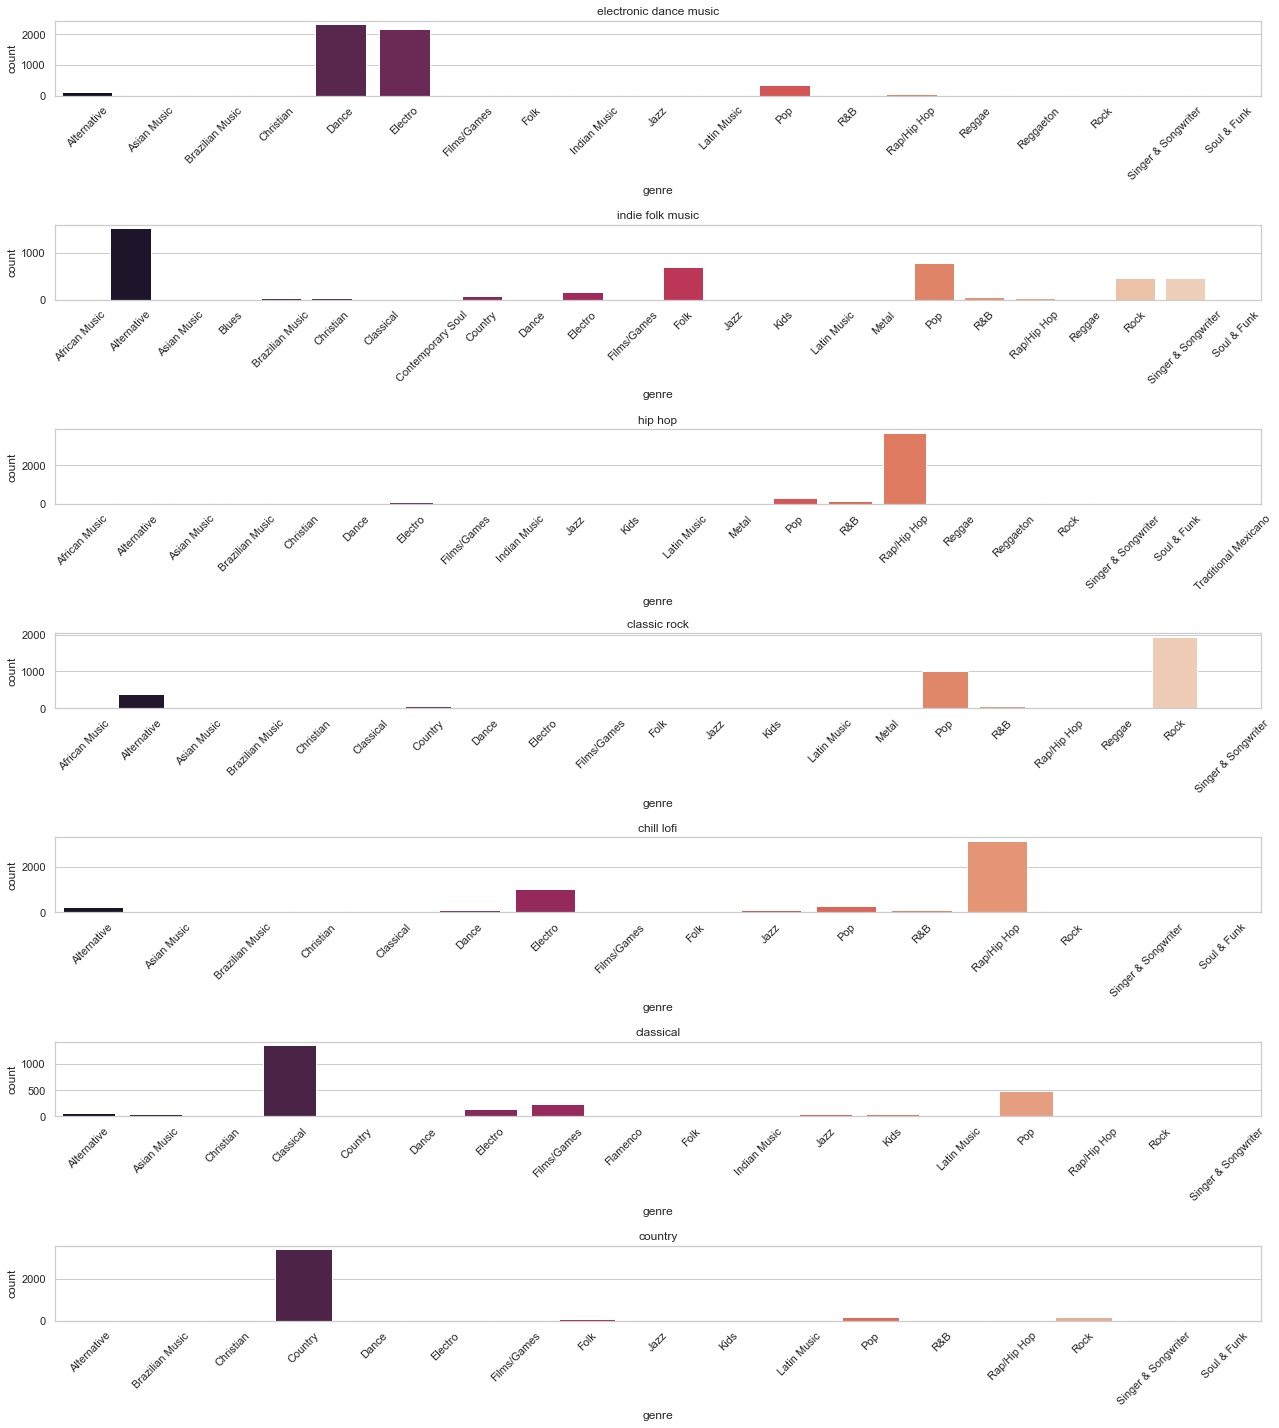

In [286]:
# Genre breakdown
fig, ax = plt.subplots(len(pl_names), 1, figsize=(18, 20))

row = 0

for pl in playlists:
    genre_graph_data = data[data['label']==pl].groupby('genre', as_index=False).agg(
        count=pd.NamedAgg(column='genre', aggfunc='count')
    )
    plot = sns.barplot(ax=ax[row], x='genre', y='count', data=genre_graph_data, palette='rocket')
    ax[row].set_title(pl)
    for item in plot.get_xticklabels():
        item.set_rotation(45)
    row += 1
plt.tight_layout()
plt.show()

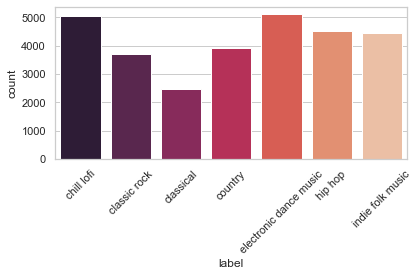

In [287]:
# barplot of class sizes
class_sizes = data.groupby('label', as_index=False).agg(
    count=pd.NamedAgg(column='label', aggfunc='count')
)

plot = sns.barplot(x='label', y='count', data=class_sizes, palette='rocket')
for item in plot.get_xticklabels():
        item.set_rotation(45)
plt.tight_layout()

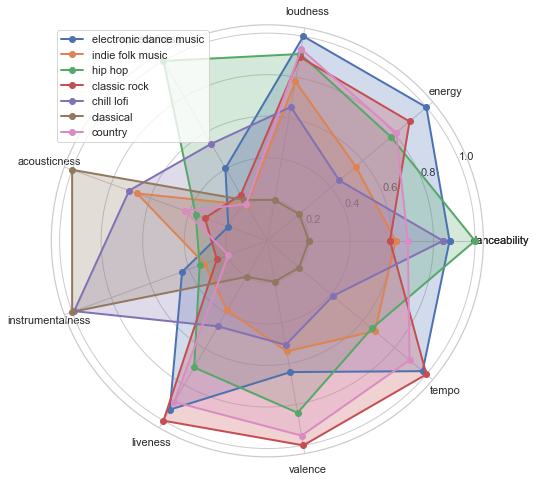

In [288]:
'''
[1] Radar chart to compare average feature values between playlists

Generate dataframe with n rows for n playlists and feature values in the columns.
1. Reshape dataframe so each row has a playlist name of a song with the song's features
2. Take the mean for each column within the playlist name
3. Normalize the columns for each feature

playlist | feature 1 | feature 2 | feature 3 | ... 
---------+-----------+-----------+-----------+ ...
pl_1     |    0.5    |    0.8    |    0.9    | ...

'''
from sklearn.preprocessing import MinMaxScaler

pls_df = pd.DataFrame(columns = ['label'] + features)

for item in playlists:
    pl_df = data[data['label']==item]
    pl_df = pl_df[['label'] + features]
    pl_averages = pl_df.groupby('label', as_index=False).mean()
    pls_df = pls_df.append(pl_averages, ignore_index=True)

scaler = MinMaxScaler(feature_range=(0.2, 1))

pls_df_scaled = pd.DataFrame(columns = ['label'] + features)
pls_df_values_scaled = scaler.fit_transform(pls_df[features].values)

i = 0
for row in pls_df_values_scaled:
    pls_df_scaled_row = dict(zip(features, row))
    pls_df_scaled_row['playlist'] = playlists[i]
    pls_df_scaled = pls_df_scaled.append(pls_df_scaled_row, ignore_index=True)
    i+=1

fig = plt.figure()
ax = fig.add_axes([0.30, 0.2, 1.5, 1.5], polar=True)
labels = np.array(features)

for index, row in pls_df_scaled.iterrows():
    stats = pls_df_scaled.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, np.array(features + [features[0]]))
    ax.legend(playlists)
    ax.grid(True)

In [291]:
for feature in features:
    feature_averages = pd.DataFrame(columns=['label', 'avg_value'])
    for pl in playlists:
        feature_averages = data.groupby('label').agg(
            average=pd.NamedAgg(column=feature, aggfunc='mean')
        )
        print(feature_averages)

                         average
label                           
chill lofi              0.649741
classic rock            0.525227
classical               0.334789
country                 0.566999
electronic dance music  0.664991
hip hop                 0.724678
indie folk music        0.538468
                         average
label                           
chill lofi              0.649741
classic rock            0.525227
classical               0.334789
country                 0.566999
electronic dance music  0.664991
hip hop                 0.724678
indie folk music        0.538468
                         average
label                           
chill lofi              0.649741
classic rock            0.525227
classical               0.334789
country                 0.566999
electronic dance music  0.664991
hip hop                 0.724678
indie folk music        0.538468
                         average
label                           
chill lofi              0.649741
classic ro

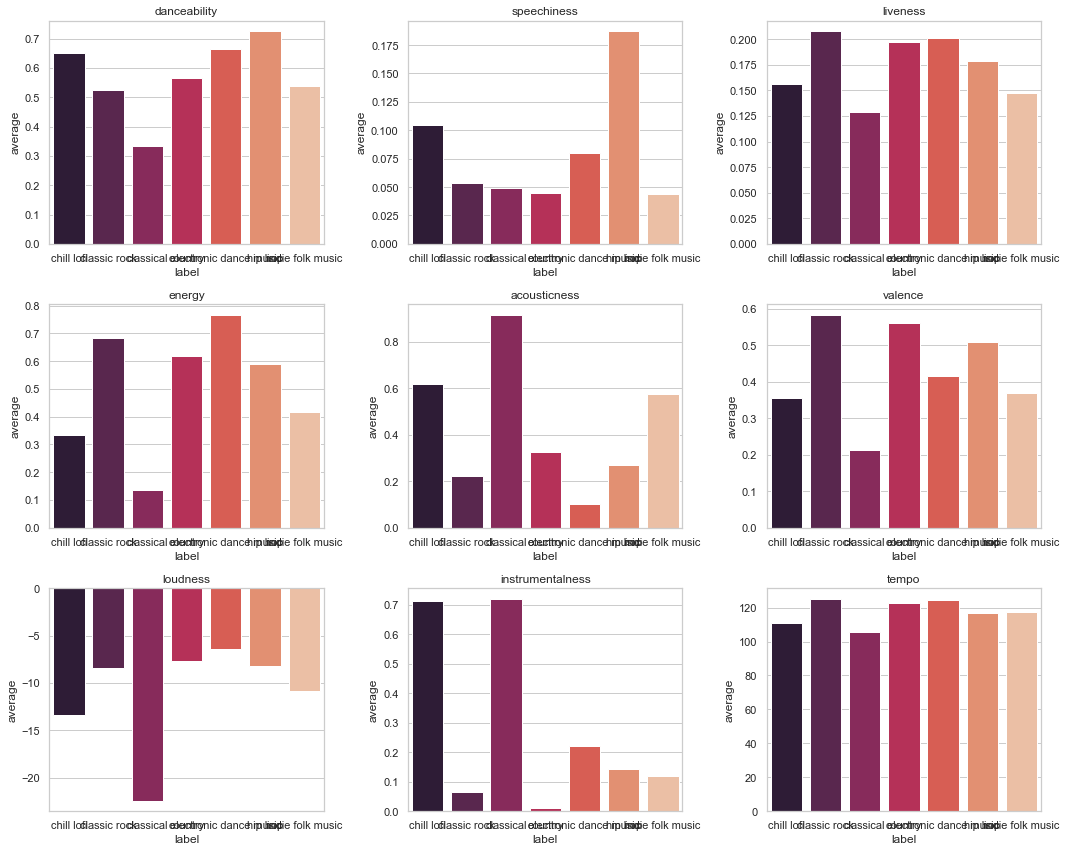

In [292]:
'''
[1] Compare average across playlists for each feature (9 total bar charts):

Generate subplot with one plot per feature

For each feature:
    1. Reorganize master data into the following dataframe structure:
    class name | average value in that class
    2. Generate barplot of average feature value for each class
'''
features = [
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo'
           ]

fig, ax = plt.subplots(3, 3, figsize=(15, 12))

row = 0
col = 0

for feature in features:
    feature_averages = pd.DataFrame(columns=['label', 'avg_value'])
    for pl in playlists:
        feature_averages = data.groupby('label', as_index=False).agg(
            average=pd.NamedAgg(column=feature, aggfunc='mean')
        )
    
    sns.barplot(ax=ax[row, col], x='label', y='average', data=feature_averages, palette='rocket')
    ax[row, col].set_title(feature)

    if row < 3 - 1:
        row += 1
    else:
        row = 0
        col += 1

plt.tight_layout()
plt.show()

### Class Similarity Analysis
The goal of this analysis is to check average similarity (using L2 distance) between classes to understand how similarity of features within the data impact model performance. To do this, the master dataset will be sliced between different sets of classes to produce different similarity scores and capture corresponding model performance. Specifically, this entails:
- Checking number of overlaps between playlists
- Calculating similarity score between the playlists

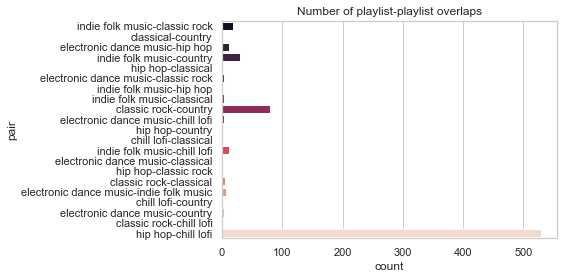

In [310]:
'''
[3] Overlap summary graph: Count how many times each playlist overlaps with another playlist (n(n-1)/2 possible combinations)
Requires generation of all possible length-2 combinations of the playlists selected, filtering to instances where those combinations occur, then counting those instances
'''
import itertools
from sklearn import preprocessing

n_playlists = len(playlists)
n_pairs = int(n_playlists*(n_playlists-1)/2)

# pair_inds generates all possible length-2 combinations of matches by list index in pl_names
pair_inds = list(set((itertools.combinations(list(range(n_playlists)), 2))))

pairs = [[playlists[pair_ind[0]], playlists[pair_ind[1]]] for pair_ind in pair_inds]

pairs_df = pd.DataFrame(columns=['pair', 'count'])

overlap_data = data_wtrackid.groupby('trackid', as_index=False)['trackid', 'label'].transform(lambda x: ''.join(x)).drop_duplicates()

for pair in pairs:
    pair_name = pair[0] + '-' + pair[1]
    pair_filter = (overlap_data['label'].str.contains(pair[0])) & \
                  (overlap_data['label'].str.contains(pair[1]))
    pair_count = len(overlap_data[pair_filter].index)
    pairs_df = pairs_df.append({'pair': pair_name, 'count': pair_count}, ignore_index=True)

ax = sns.barplot(x='count', y='pair', data=pairs_df, palette="rocket")
plt.title('Number of playlist-playlist overlaps')
plt.show()


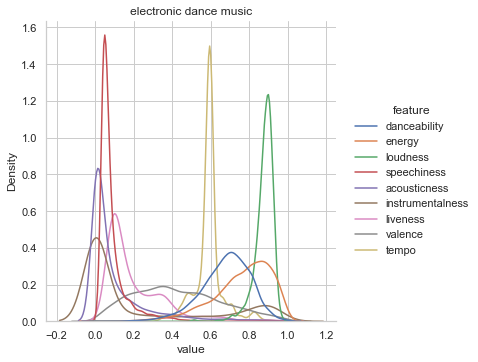

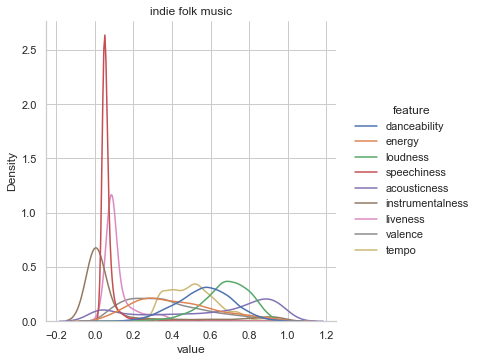

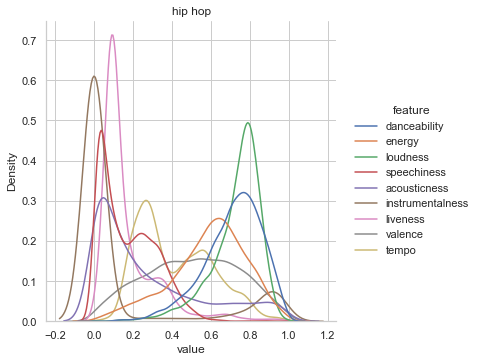

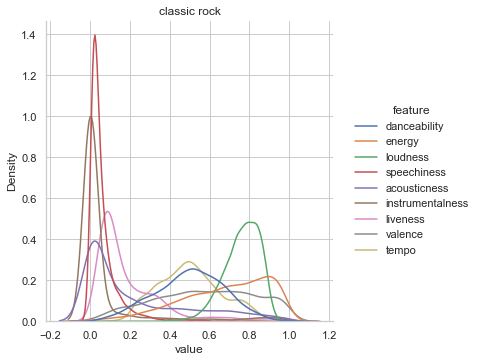

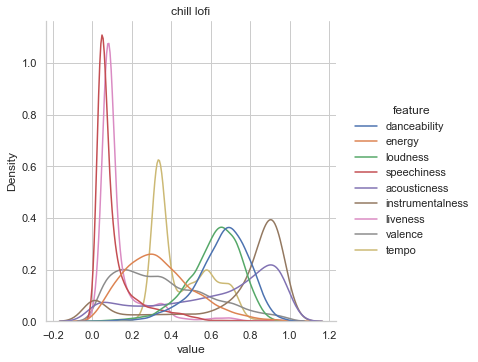

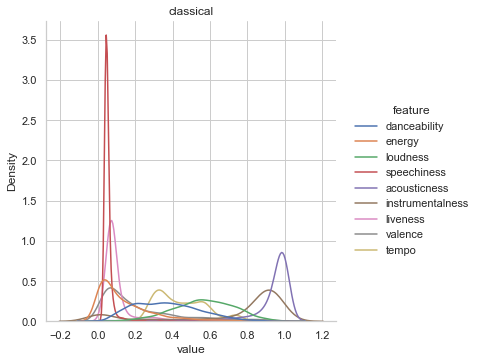

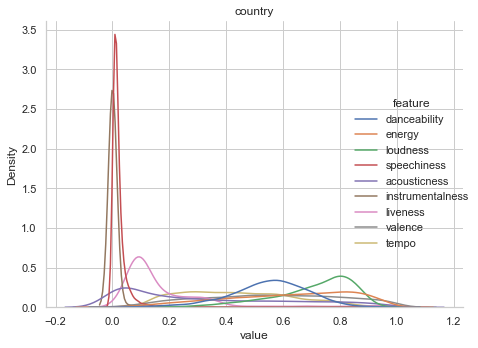

In [312]:
'''
[4] Compare spread across features for each playlist (4 total prob density function plots)

For each playlist, plot the following dataframe format (plot each track individually):
feature | value

This requires normalization of feature values using sklearn.preprocessing
'''
scaler = MinMaxScaler()

for pl in playlists:
    pl_features_df = pd.DataFrame(columns=['feature', 'value'])
    for feature in features:
        # Scale values first!
        pl_features = data[data['label']==pl][feature].to_numpy().reshape(-1, 1)
        pl_features = pd.DataFrame(scaler.fit_transform(pl_features))
        pl_features['feature'] = feature
        pl_features.columns = ['value', 'feature']
        pl_features_df = pl_features_df.append(pl_features, ignore_index=True)
    
    sns.displot(x='value', data=pl_features_df, hue='feature', kind='kde')
    plt.title(pl)

plt.tight_layout()
plt.show()


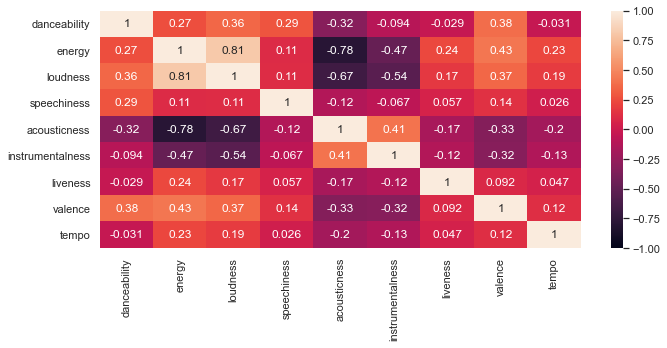

In [313]:
'''
[5] Check for multicollinearity between features 
'''

ppdata = data[features]

fig, ax = plt.subplots(1, figsize=(10, 5))

sns.heatmap(ppdata.corr(), ax=ax, vmin=-1, vmax=1, annot=True)

plt.tight_layout()
plt.show()

### Model Building
<b>General solution:</b> Since I am predicting multiple classes, build multiple binary classifiers (one per class) to run in parallel that each predict whether each song does / does not belong to one class. 

<b>Potential evaluation metrics for multiple class predictions:</b>
- Hamming Score: fraction of individual labels incorrectly predicted
- Microaveraged F1 and ROC AUC: F1 and ROC AUC but calculated using TP, TN, FP, and FN rates averaged across each class
- Subset accuracy: fraction of perfect matches

<b>Classification models to try:</b>
- Logistic Regression
- Random Forest
- Support Vector Machine

In [327]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, hamming_loss
from collections import Counter

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

binarizer = binarize(df=data_wtrackid, feature_var='genre', label_var='label', id_col='trackid')
model_data = binarizer['data']

X = model_data[features + binarizer['genre']]
y = model_data[binarizer['label']]

In [337]:
'''Prepare Data'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = preprocessing.StandardScaler()
X_train_transformed = np.concatenate((scaler.fit_transform(X_train[features]), X_train[binarizer['genre']].to_numpy()), axis=1)
X_test_transformed = np.concatenate((scaler.fit_transform(X_test[features]), X_test[binarizer['genre']].to_numpy()), axis=1)

In [347]:
'''Logistic Regression with adjusted probability threshold'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train_transformed, y_train)

micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')
scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'f1': micro_f1}

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_train_transformed))

threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold_list:
    print('\n Classifying 1 for probabilities above {0}'.format(i))
    y_train_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    y_train_mat = y_train.to_numpy()
    y_train_pred_mat = y_train_pred.to_numpy()

    train_precision = precision_score(y_train, y_train_pred, average='micro')
    train_recall = recall_score(y_train, y_train_pred, average='micro')
    train_f1 = f1_score(y_train, y_train_pred, average='micro')

    print('Precision: {0} Recall: {1} f1 Score: {2}'.format(train_precision, train_recall, train_f1))


 Classifying 1 for probabilities above 0.1
Precision: 0.6031696119740897 Recall: 0.9386836310252019 f1 Score: 0.734421961444953

 Classifying 1 for probabilities above 0.2
Precision: 0.7330320361556614 Recall: 0.8968925862490824 f1 Score: 0.8067256481359216

 Classifying 1 for probabilities above 0.3
Precision: 0.8029944479839811 Recall: 0.8634695375581111 f1 Score: 0.832134688391615

 Classifying 1 for probabilities above 0.4
Precision: 0.847512599171698 Recall: 0.8311720088084169 f1 Score: 0.8392627730012847

 Classifying 1 for probabilities above 0.5
Precision: 0.8788666775014898 Recall: 0.7938830437974064 f1 Score: 0.8342160744587853

 Classifying 1 for probabilities above 0.6
Precision: 0.9032655214867796 Recall: 0.7539515537068755 f1 Score: 0.8218820014936521

 Classifying 1 for probabilities above 0.7
Precision: 0.9267427613335912 Recall: 0.7032542206997798 f1 Score: 0.7996772578042401

 Classifying 1 for probabilities above 0.8
Precision: 0.9478388278388279 Recall: 0.633129434

In [196]:
'''Logistic Regression'''
# Instantiate LogisticRegression classifier (estimator) for cross validation
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

# Perform grid search cross validation for hyperparameter tuning
micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')
ham_loss = make_scorer(hamming_loss)

parameters = {'estimator__C': [0.5, 1, 2, 3, 4, 5]}

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'micro_f1': micro_f1, 'ham_loss': ham_loss}
cv_score = {'micro_precision': micro_precision}

multilogreg_gs = GridSearchCV(multilogreg, parameters, refit=cv_score)
multilogreg_gs.fit(X_train_transformed, y_train)
print('Best combination: {0}\n'.format(multilogreg_gs.best_params_))

logreg_scores = cross_validate(multilogreg, X_train_transformed, y_train, scoring=scoring)
logreg_scores_optimal = cross_validate(multilogreg_gs.best_estimator_, X_train_transformed, y_train, scoring=scoring)

print('CV Scores Before Optimization:')
for key in logreg_scores:
    print('{0}: {1}'.format(key, logreg_scores[key]))

print('CV Scores After Optimization:')
for key in logreg_scores_optimal:
    print('{0}: {1}'.format(key, logreg_scores_optimal[key]))

Best combination: {'estimator__C': 5}

CV Scores Before Optimization:
fit_time: [0.86754823 0.3838222  0.73895621 0.40255642 0.78965449]
score_time: [0.02083302 0.01923251 0.01773286 0.02792454 0.01773429]
test_micro_precision: [0.71760391 0.73701703 0.7242088  0.70162297 0.72271762]
test_micro_recall: [0.43214724 0.43342292 0.43154543 0.4119228  0.4160352 ]
test_micro_f1: [0.53943942 0.54584615 0.54082259 0.51908867 0.52807943]
test_ham_loss: [0.10763504 0.10566632 0.10709811 0.11182303 0.10891515]
CV Scores After Optimization:
fit_time: [0.36406922 0.75544572 0.37165952 0.72883224 0.53868341]
score_time: [0.01882863 0.01733208 0.01878858 0.01897836 0.03561974]
test_micro_precision: [0.71765663 0.73620904 0.72354389 0.70170337 0.72252864]
test_micro_recall: [0.43288344 0.43366724 0.43203527 0.41265575 0.41627964]
test_micro_f1: [0.54002755 0.54581796 0.54102132 0.51969231 0.52822581]
test_ham_loss: [0.10756345 0.10573791 0.10713391 0.11175144 0.10891515]


In [33]:
# Instantiate SVM classifier (estimator) for cross validation
multisvm = SVC()

# Perform grid search cross validation for hyperparameter tuning
micro_precision = make_scorer(precision_score)
micro_recall = make_scorer(recall_score)
micro_f1 = make_scorer(f1_score)
ham_loss = make_scorer(hamming_loss)

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'micro_f1': micro_f1, 'hamming_loss': ham_loss}

In [34]:
# Raw data as is
for pl in pl_names:
    print('Playlist: {0}'.format(pl))

    y_train_indiv = y_train[pl]
    svm_scores = cross_validate(multisvm, X_train_transformed, y_train_indiv, scoring=scoring)

    for key in svm_scores:
        if key != 'fit_time' and key != 'score_time':
            print('{0}  mean: {1}   std: {2}'.format(key, svm_scores[key].mean(), svm_scores[key].std()))
    print('\n')

Playlist: electronic dance music
test_micro_precision  mean: 0.6208287668169872   std: 0.026805529723614992
test_micro_recall  mean: 0.4284526848241751   std: 0.031413022319852886
test_micro_f1  mean: 0.5064535729180997   std: 0.02683768537773441
test_hamming_loss  mean: 0.26436507332097925   std: 0.011373565855896205


Playlist: rap / hip hop
test_micro_precision  mean: 0.6019675828983998   std: 0.01646982403635168
test_micro_recall  mean: 0.316952666129218   std: 0.016795345475118035
test_micro_f1  mean: 0.41507819581178634   std: 0.016689571983743698
test_hamming_loss  mean: 0.27917274266625675   std: 0.005572808307542391


Playlist: lofi study
test_micro_precision  mean: 0.6571249870478285   std: 0.02232962623948459
test_micro_recall  mean: 0.5829944547134935   std: 0.018171099042431804
test_micro_f1  mean: 0.6177295176151035   std: 0.018282064625756805
test_hamming_loss  mean: 0.26765518596554566   std: 0.01374548488946432




### Troubleshooting my data
<b>Problem:</b> Precision / Recall / F1 is highly sensitive to playlist name inputs and drops significantly for > 2 or 3 classes. Need to make models more robust

<b>Potential causes</b>
- <b>Class imbalances:</b> one binary classifier used for each class, and each class has much fewer positive signals than negative (becomes more pronounced with increasing n classes)
- <b>Misalignment in goal:</b> the 0 label is not necessarily a strong signal that a song <u>doesn't</u> belong in a class
- <b>Need more features to differentiate between classes

<b>Reassessing the Goal</b>
- As a user, I'd prefer that this tool skew towards false negatives than false positives. Better a playlist with a few songs missing than a playlist with songs in it that don't belong
- Optimize for precision / recall / f1 (measure of TP / FP / FN), with precision (TP/(TP+FP)) being the priority

<b>Potential next steps</b>
- SVM transformation of feature space may yield additional gains in class differentials
- Oversampling / Undersampling technique may improve performance - look into imblearn library (SMOTE specifically)
- Find additional features to add to song data (that can be replicated for my own Spotify music)

### Experimenting with Potential Next Steps using RandomForest Classifier
Here we evaluate a RandomForest classifier under 3 conditions:
- Raw data as is
- Raw data with oversampling (SMOTE)
- Raw data with partial oversampling (SMOTE), followed by undersampling

In [ ]:
# Instantiate RandomForest classifier (estimator) for cross validation
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Establish scoring metrics
micro_precision = make_scorer(precision_score)
micro_recall = make_scorer(recall_score)
micro_f1 = make_scorer(f1_score)

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'f1': micro_f1}    

In [162]:
# Raw data as is
for pl in pl_names:
    print('Playlist: {0}'.format(pl))

    y_train_indiv = y_train[pl]
    rf_scores = cross_validate(rf, X_train, y_train_indiv, scoring=scoring)
    
    for key in rf_scores:
        if key != 'fit_time' and key != 'score_time':
            print('{0}  mean: {1}   std: {2}'.format(key, rf_scores[key].mean(), rf_scores[key].std()))
    print('\n')

Playlist: electronic dance music
test_micro_precision  mean: 0.5268521832142461   std: 0.03306232159533514
test_micro_recall  mean: 0.24304892110031298   std: 0.013001400007727655
test_f1  mean: 0.3323718654995069   std: 0.016525776009432783


Playlist: rap / hip hop
test_micro_precision  mean: 0.47950721121980966   std: 0.012403065513102676
test_micro_recall  mean: 0.13902207698303143   std: 0.0037542103997065344
test_f1  mean: 0.2154855731865349   std: 0.004351361211017409


Playlist: lofi study
test_micro_precision  mean: 0.4716728124369493   std: 0.026575073917961285
test_micro_recall  mean: 0.21343570057581576   std: 0.017482222705160384
test_f1  mean: 0.29319938200162854   std: 0.016784888309214006


Playlist: chill vibes
test_micro_precision  mean: 0.450939888577786   std: 0.06367302521278251
test_micro_recall  mean: 0.06098009730207873   std: 0.01106772862918408
test_f1  mean: 0.1073318006852663   std: 0.018868610315383293




<b>Result:</b> Without any resampling, f1 was pretty poor, but with stable results on the training set indicated by the low score std.

In [167]:
# Raw data with oversampling (SMOTE) - upsamples the minority class (1) to match the size of the majority class (0)
# More info at https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
for pl in pl_names:
    print('Playlist: {0}'.format(pl))

    y_train_indiv = y_train[pl]
    counter1 = Counter(y_train_indiv)

    smote = SMOTE()
    
    X_smote, y_smote = smote.fit_resample(X_train, y_train_indiv)
    counter2 = Counter(y_smote)

    print(counter1, counter2)

    rf_scores = cross_validate(rf, X_smote, y_smote, scoring=scoring)
    
    for key in rf_scores:
        if key != 'fit_time' and key != 'score_time':
            print('{0}  mean: {1}   std: {2}'.format(key, rf_scores[key].mean(), rf_scores[key].std()))
    print('\n')

Playlist: electronic dance music
Counter({0: 6920, 1: 2337}) Counter({1: 6920, 0: 6920})
test_micro_precision  mean: 0.7941544065289576   std: 0.017439093836631288
test_micro_recall  mean: 0.7729768786127168   std: 0.09749078009508591
test_f1  mean: 0.7811725458176099   std: 0.06012076513656471


Playlist: rap / hip hop
Counter({0: 6948, 1: 2309}) Counter({0: 6948, 1: 6948})
test_micro_precision  mean: 0.7598203730584931   std: 0.03471172418118958
test_micro_recall  mean: 0.7616564890636086   std: 0.1124246832668026
test_f1  mean: 0.7585096833141179   std: 0.07398196841180203


Playlist: lofi study
Counter({0: 6652, 1: 2605}) Counter({0: 6652, 1: 6652})
test_micro_precision  mean: 0.7412044074971333   std: 0.022594096249831226
test_micro_recall  mean: 0.7520756059947014   std: 0.12346336388017788
test_f1  mean: 0.7430774837036993   std: 0.07411817612098938


Playlist: chill vibes
Counter({0: 6879, 1: 2378}) Counter({0: 6879, 1: 6879})
test_micro_precision  mean: 0.7335027423367674   st

<b>Result:</b> SMOTE oversampling seems to significantly boost to precision, recall, and f1 performance, but with a significant increase in std. This may be because the burden of resampling was on SMOTE, which is stochastic and creates new data points through interpolation. To reduce this burden, next experiment combines SMOTE with undersampling of the majority set

In [164]:
# Raw data with oversampling (SMOTE) and undersampling - upsample the minority class to 60% of the majority class size, then downsample the majority class to meet the partially upsampled minority class size, resulting in equally sized classes
for pl in pl_names:
    print('Playlist: {0}'.format(pl))

    y_train_indiv = y_train[pl]
    counter1 = Counter(y_train_indiv)

    smote = SMOTE(sampling_strategy=0.5)
    under = RandomUnderSampler()
    steps = [('o', smote), ('u', under)]
    pipeline = Pipeline(steps=steps)
    
    X_smote, y_smote = pipeline.fit_resample(X_train, y_train_indiv)
    counter2 = Counter(y_smote)

    print(counter1, counter2)

    rf_scores = cross_validate(rf, X_smote, y_smote, scoring=scoring)
    
    for key in rf_scores:
        if key != 'fit_time' and key != 'score_time':
            print('{0}  mean: {1}   std: {2}'.format(key, rf_scores[key].mean(), rf_scores[key].std()))
    print('\n')

Playlist: electronic dance music
Counter({0: 6920, 1: 2337}) Counter({0: 3460, 1: 3460})
test_micro_precision  mean: 0.7393437286057991   std: 0.019930796458725822
test_micro_recall  mean: 0.6638728323699421   std: 0.08034266217873365
test_f1  mean: 0.6979982372655853   std: 0.051761494340504616


Playlist: rap / hip hop
Counter({0: 6948, 1: 2309}) Counter({0: 3474, 1: 3474})
test_micro_precision  mean: 0.6950915215957886   std: 0.026260984993564017
test_micro_recall  mean: 0.6522957311384322   std: 0.09397921833924021
test_f1  mean: 0.670575941141098   std: 0.057662549407989705


Playlist: lofi study
Counter({0: 6652, 1: 2605}) Counter({0: 3326, 1: 3326})
test_micro_precision  mean: 0.6780540547060399   std: 0.01741360364020307
test_micro_recall  mean: 0.6371144076407235   std: 0.069947097406472
test_f1  mean: 0.6556112477769365   std: 0.0420169143542378


Playlist: chill vibes
Counter({0: 6879, 1: 2378}) Counter({0: 3439, 1: 3439})
test_micro_precision  mean: 0.6364417235953517   std

<b>Result:</b> Tried model fitted on oversampled data on test dataset - didn't seem to have a significant impact. Back to the drawing board!

### Class Similarity Analysis
The goal of this analysis is to check average similarity (using L2 distance) between classes to understand how similarity of features within the data impact model performance. To do this, the master dataset will be sliced between different sets of classes to produce different similarity scores and capture corresponding model performance. Specifically, this entails:
- Checking number of overlaps between playlists
- Calculating similarity score between the playlists

In [58]:
def Euclidean_Dist(df1, df2, cols):
    '''
    Parameters:
        - df1 and df2: features for the two classes being compared
        - cols: features to compare
        
    Function: Standardize df1 and df2 using StandardScaler, trim the longer df to match the shorter df length, then iterate row by        row and calculate average Euclidean distance between features for each song from df1 and df2
    
    Return: Average Euclidean distance between df1 and df2 (sum of Euclidean distances between features in df1 and df2 divided by         length of shorter df between the two)
    '''
    scaler = preprocessing.StandardScaler()
    df1_scaled = pd.DataFrame(scaler.fit_transform(df1[cols].values))
    df2_scaled = pd.DataFrame(scaler.fit_transform(df2[cols].values))

    if len(df1_scaled) > len(df2_scaled):
        df1_scaled = df1_scaled.iloc[0:len(df2_scaled)]
    elif len(df2_scaled) > len(df1_scaled):
        df2_scaled = df2_scaled.iloc[0:len(df1_scaled)]
    
    return np.linalg.norm(df2_scaled.values - df1_scaled.values, axis=1).sum()/min(len(df1),len(df2))

Average class similarity: 4.08987674367825


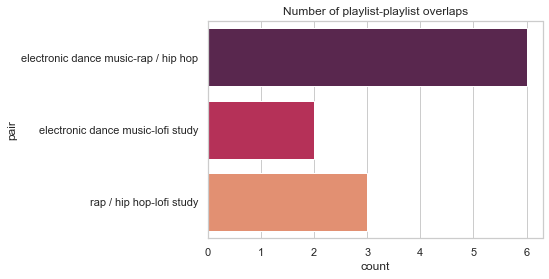

Average class similarity: 4.077312849083533


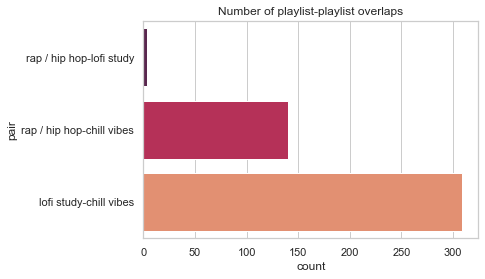

Average class similarity: 4.037063985739015


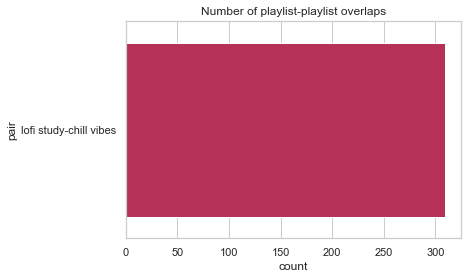

Average class similarity: 4.067603564695227


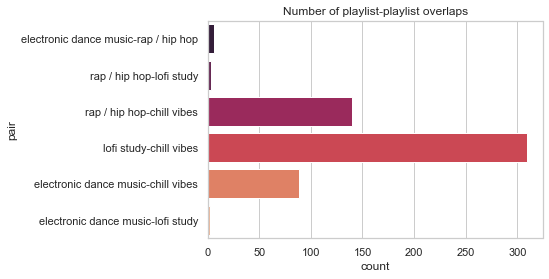

[12.26963023103475, 12.2319385472506, 4.037063985739015, 24.405621388171358]


In [64]:
'''
[3] Overlap summary graph: Count how many times each playlist overlaps with another playlist (n(n-1)/2 possible combinations)
Requires generation of all possible length-2 combinations of the playlists selected, filtering to instances where those combinations occur, then counting those instances
'''
import itertools

pl_names_sets = [pl_names[:3], pl_names[1:], pl_names[2:], pl_names]
difference_scores = []

for pl_names_set in pl_names_sets:
    n_playlists = len(pl_names_set)
    n_pairs = int(n_playlists*(n_playlists-1)/2)

    # pair_inds generates all possible length-2 combinations of matches by list index in pl_names
    pair_inds = list(set((itertools.combinations(list(range(n_playlists)), 2))))
    pairs = [[pl_names_set[pair_ind[0]], pl_names_set[pair_ind[1]]] for pair_ind in pair_inds]
    pairs_df = pd.DataFrame(columns=['pair', 'count'])

    difference_score = 0

    for pair in pairs:
        pl1_features = data[data[pair[0]]==1]
        pl2_features = data[data[pair[1]]==1]
        difference_score += Euclidean_Dist(pl1_features, pl2_features, features)

        pair_name = pair[0] + '-' + pair[1]
        pair_filter = (data[pair[0]]==1) & (data[pair[1]]==1)
        pair_count = len(data[pair_filter].index)
        pairs_df = pairs_df.append({'pair': pair_name, 'count': pair_count}, ignore_index=True)
    
    ax = sns.barplot(x='count', y='pair', data=pairs_df, palette="rocket")
    plt.title('Number of playlist-playlist overlaps')
    print('Average class similarity: {0}'.format(difference_score/len(pairs)))
    plt.show()
    
    difference_scores.append(difference_score)

scaler = preprocessing.MinMaxScaler(feature_range=(0.2, 1))
#difference_scores = scaler.fit_transform(np.array(difference_scores).reshape(-1, 1))
print(difference_scores)